In this notebook, hyperopt-sklearn is used to find alternative optimal paramters for the Gradient Boosting Classifier model as applied to transit detection. 

This will be used to compare the partial dependence plots of two seperately trained models to see if feature interaction has strong variation across models. 

If there is high amounts of variability in the interaction between two features partial dependence across models then the physical truth of these feature interactions must be questioned. IE is the observed interaction due to chance or due to physical significance of the interaction features. 

There has already been some evidence that having alternative models changes how the features partial dependence interacts, however we must bear in mind that the model cannot create information that isn't present in the data.

In the previous notebook on the topic, a small subset of the parameter space was tuned using hyper-opt, in this notebook only the features that were tuned in the original replication of the XGBoost results will be tuned, to see the extent of the variation across the PDPs. 

In the notebook following this one, the full feature set will be tested.

In [3]:
import pandas as pd
import numpy as np
from sklearn import cross_validation, metrics   
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import operator 
import xgboost as xgb
from xgboost.sklearn import XGBClassifier 
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
trainData = pd.read_csv('1e7data_train.csv', index_col=0)
testData = pd.read_csv('1e7data_holdout.csv', index_col=0)
df = trainData
dftest = testData

feature_names = ['daOverRH1', 'daOverRH2', 'mindaOverRH', 'maxdaOverRH','norm_std_a1',
                 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1',
                'norm_std_a2', 'norm_std_window10_a2', 'norm_max_window10_a2', 'norm_max_a2',
                'norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3', 
                'avg_ecross1', 'std_ecross1', 'min_ecross1', 'max_ecross1', 
                'avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2',
                'avg_ecross3', 'max_ecross3', 'min_ecross3', 'std_ecross3', 
                'norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope', 'norm_LyapunovTime']

X_train = df[feature_names]


y_train = df['Stable']
X_test = dftest[feature_names]

X_train = X_train.replace(np.nan, -999)
X_train = X_train.replace(np.inf, -999)

X_test = X_test.replace(np.nan, -999)
X_test = X_test.replace(np.inf, -999)



/home/tom/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The original replication model:

In [4]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(loss='deviance', learning_rate=0.002, n_estimators=5000,
                                  subsample=.5,  min_samples_split=2, 
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=8,
                                  init=None, random_state=42, 
                                  max_leaf_nodes=8, warm_start=False, max_features=.5)

model.fit(X_train, y_train)

dtest_predictions = model.predict(X_test) 
dtest_predprob = model.predict_proba(X_test)[:, 1]

#Print model report:
print "\nModel Report"
print "Accuracy : %.4g" % metrics.accuracy_score(dftest['Stable'].values, dtest_predictions)
print "AUC Score (Test): %f" % metrics.average_precision_score(dftest['Stable'], dtest_predprob)
print 'ROC_AUC_Score: ', metrics.roc_auc_score(dftest['Stable'], dtest_predprob)


Model Report
Accuracy : 0.8873
AUC Score (Test): 0.895186
ROC_AUC_Score:  0.945591898717


In [3]:
from hpsklearn import HyperoptEstimator
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

max_leaf_n = [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


def hyperopt_train_test(params):
    clf = GradientBoostingClassifier(**params)
    return cross_val_score(clf, X_train, y_train, cv=4, scoring='roc_auc').mean()

# the parameter space we'll be tuning across. 
space4gbc = {
    'learning_rate': hp.choice('learning_rate', np.array(range(1, 10))/100.), 
    'n_estimators': hp.choice('n_estimators', np.array(range(100, 10000, 100))), 
    'subsample': hp.choice('subsample', np.array(range(5, 10))/10.),
    'max_depth': hp.choice('max_depth', np.array(range(3, 11))),
    'max_features': hp.choice('max_features', np.array(range(5, 10))/10.),
    'max_leaf_nodes':hp.choice('max_leaf_nodes', np.array(max_leaf_n))

}

# the parameters that were skipped above such as min_samples_split, were not tuned during the replication
# so are left as default until the next notebook. 

best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
        print 'new best:', best, params
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4gbc, algo=tpe.suggest, max_evals=1500, trials=trials)
print 'best:'
print best

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely
new best: 0.952462768048 {'n_estimators': 2000, 'subsample': 0.90000000000000002, 'max_features': 0.59999999999999998, 'max_leaf_nodes': 12, 'learning_rate': 0.01, 'max_depth': 5}
new best: 0.953063327974 {'n_estimators': 4700, 'subsample': 0.80000000000000004, 'max_features': 0.5, 'max_leaf_nodes': 13, 'learning_rate': 0.029999999999999999, 'max_depth': 6}
new best: 0.953191292157 {'n_estimators': 7200, 'subsample': 0.59999999999999998, 'max_features': 0.80000000000000004, 'max_leaf_nodes': 11, 'learning_rate': 0.01, 'max_depth': 8}
new best: 0.953395506495 {'n_estimators': 9500, 'subsample': 0.80000000000000004, 'max_features': 0.90000000000000002, 'max_leaf_nodes': None, 'learning_rate': 0.01, 'max_depth': 8}
new best: 0.953917105993 {'n_estimators': 2800, 'subsample': 0.69999999999999996, 'max_features': 0.80000000000000004, 'max_

KeyboardInterrupt: 

The score is quite high now and the parameters are sufficiently different so we can stop the trials (took ~ 8 - 12 h)

Now we input the optimal parameters and observe both the change in test scores and the importance/PDP changes. 

In [5]:
# tuned model
model = GradientBoostingClassifier(max_features= .5, n_estimators= 5900, 
                                   learning_rate = .01,
                                   max_depth= 9,
                                   subsample= .8, max_leaf_nodes=None)

model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=9,
              max_features=0.5, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=5900, presort='auto', random_state=None,
              subsample=0.8, verbose=0, warm_start=False)

In [6]:
dtest_predictions = model.predict(X_test) 
dtest_predprob = model.predict_proba(X_test)[:, 1]

#Print model report:
print "\nModel Report"
print "Accuracy : %.4g" % metrics.accuracy_score(dftest['Stable'].values, dtest_predictions)
print "AUC Score (Test): %f" % metrics.average_precision_score(dftest['Stable'], dtest_predprob)
print 'ROC_AUC_Score: ', metrics.roc_auc_score(dftest['Stable'], dtest_predprob)


Model Report
Accuracy : 0.8893
AUC Score (Test): 0.901301
ROC_AUC_Score:  0.951841045591


The testing data score from the XGBoost Model: 

Model Report Accuracy : 0.89

PR_AUC Score : 0.901043 

ROC_AUC_Score: o.949938574939


The next cell scales the feature importance values up to the range that XGBoost reports feature importance for comparison. (The three can be found in the Notable Changes Notebook). 

It also sorts the values, and names according to the scores and then plots. 

In [7]:
vals = model.feature_importances_*100000

val_dict = dict(zip(feature_names, vals))
sorted_vals = sorted(val_dict.items(), key = operator.itemgetter(1), reverse=True)

feature_names_sorted = []
for scores in sorted_vals: 
    feature_names_sorted.append(scores[0])

vals_sorted = sorted(vals, reverse=True)



32


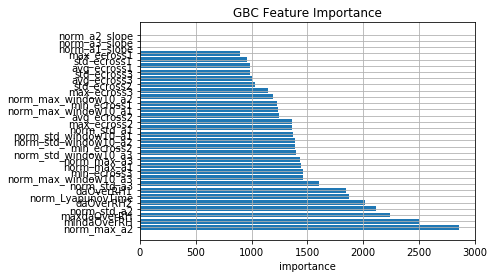

['norm_max_a2', 'mindaOverRH', 'maxdaOverRH', 'norm_std_a2', 'daOverRH2', 'norm_LyapunovTime', 'daOverRH1', 'norm_std_a3', 'norm_max_window10_a3', 'min_ecross3', 'norm_max_a1', 'norm_max_a3', 'norm_std_window10_a3', 'min_ecross2', 'norm_std_window10_a2', 'norm_std_window10_a1', 'norm_std_a1', 'max_ecross2', 'avg_ecross2', 'norm_max_window10_a1', 'min_ecross1', 'norm_max_window10_a2', 'max_ecross3', 'std_ecross2', 'avg_ecross3', 'std_ecross3', 'avg_ecross1', 'std_ecross1', 'max_ecross1', 'norm_a1_slope', 'norm_a3_slope', 'norm_a2_slope']


In [8]:
from pylab import *

points = vals_sorted

pos = arange(len(vals_sorted)) + .5 # centres the graph along y 

figure(1) 
barh(pos, vals_sorted, align='center') 
yticks(pos, feature_names_sorted)
xlabel('importance')
title('GBC Feature Importance')
grid(True)
show()

print(feature_names_sorted)

We are interested in the possible combinations of top 10 features so we can use pythons combinations/itertools to get the combinations

In [9]:
import itertools

comb =  list(itertools.combinations(range(0, 10), 2)) # create the possible top 10 combinations

print comb

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)]


In [12]:
%matplotlib nbagg    
%matplotlib notebook

from sklearn.ensemble.partial_dependence import partial_dependence
from mpl_toolkits.mplot3d import Axes3D

def D3_pdp(target_feature, model, X_train, names_list):
    fig = plt.figure()
    pdp, axes = partial_dependence(model, target_variables=target_feature, X=X_train, 
                                   grid_resolution=50, proba=True)
    XX, YY = np.meshgrid(axes[0], axes[1])
    Z = pdp[0].reshape(list(map(np.size, axes))).T

    ax = Axes3D(fig)
    
    surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
    ax.set_xlabel(feature_names_sorted[target_feature[0]])
    ax.set_ylabel(feature_names_sorted[target_feature[1]])
    ax.set_zlabel('Partial dependence')
    #  pretty init view
    ax.view_init(elev=22, azim=122)
    plt.colorbar(surf)
    plt.suptitle('Partial dependence of stability on {0} and {1} '.format(names_list[target_feature[0]], names_list[target_feature[1]]))
    plt.subplots_adjust(top=0.9)

    plt.show()

<IPython.core.display.Javascript object>


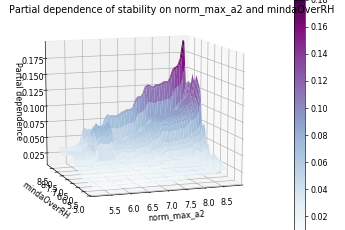

<IPython.core.display.Javascript object>


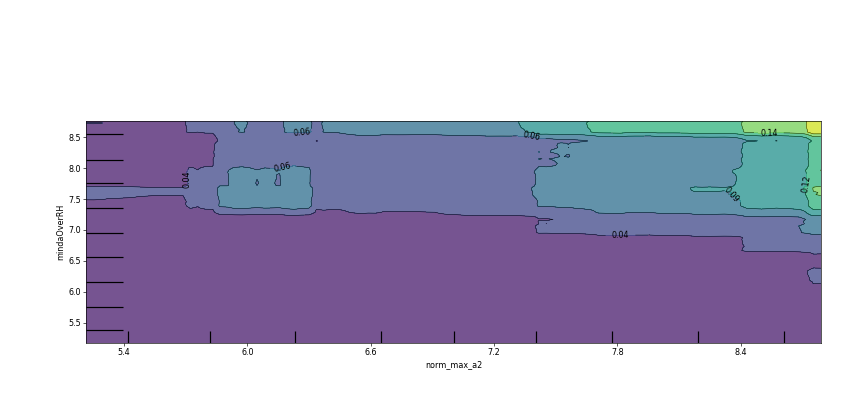

<IPython.core.display.Javascript object>


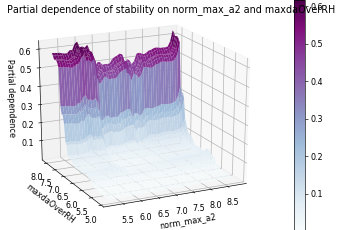

<IPython.core.display.Javascript object>


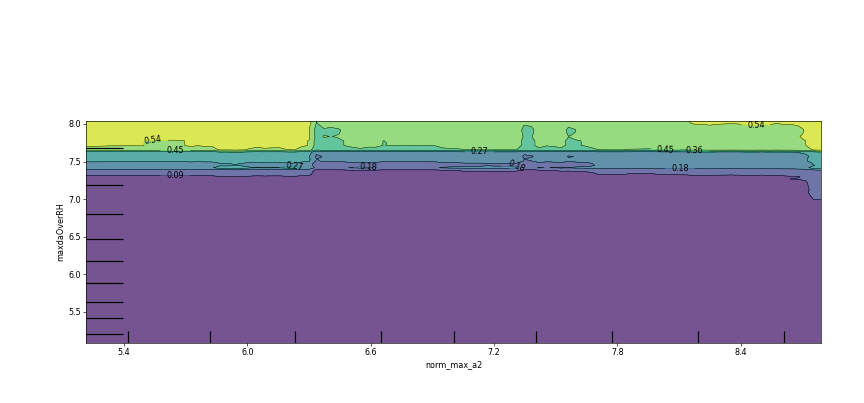

<IPython.core.display.Javascript object>


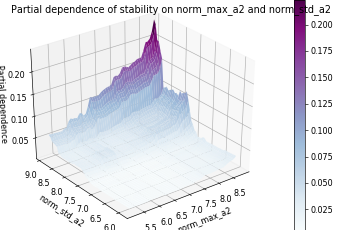

<IPython.core.display.Javascript object>


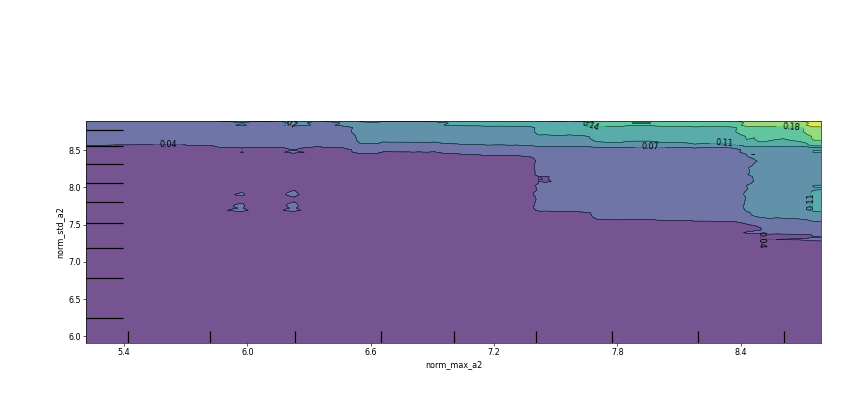

<IPython.core.display.Javascript object>


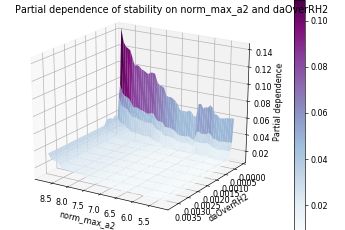

<IPython.core.display.Javascript object>


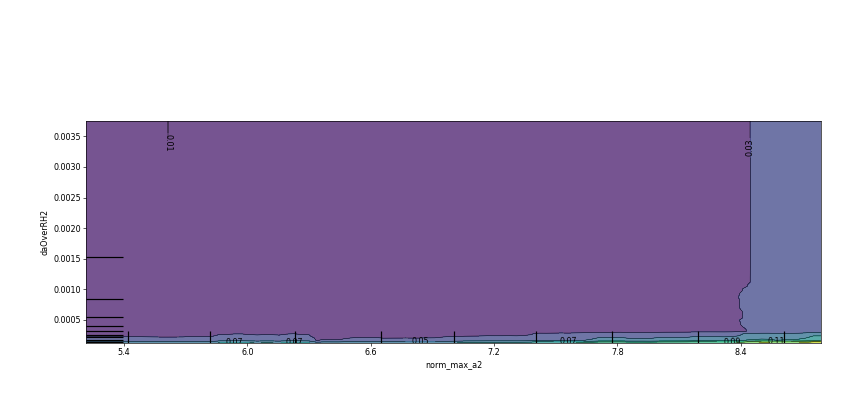

<IPython.core.display.Javascript object>


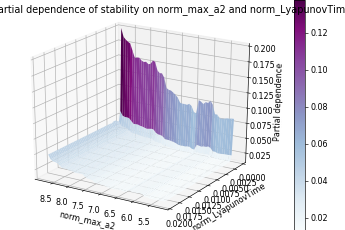

<IPython.core.display.Javascript object>


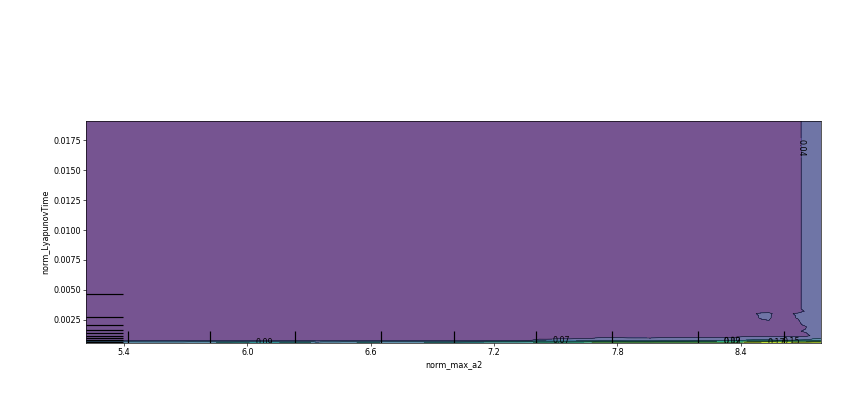

<IPython.core.display.Javascript object>


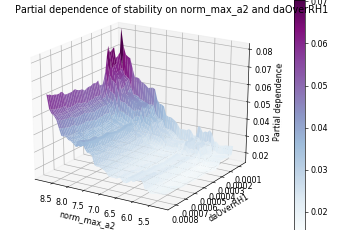

<IPython.core.display.Javascript object>


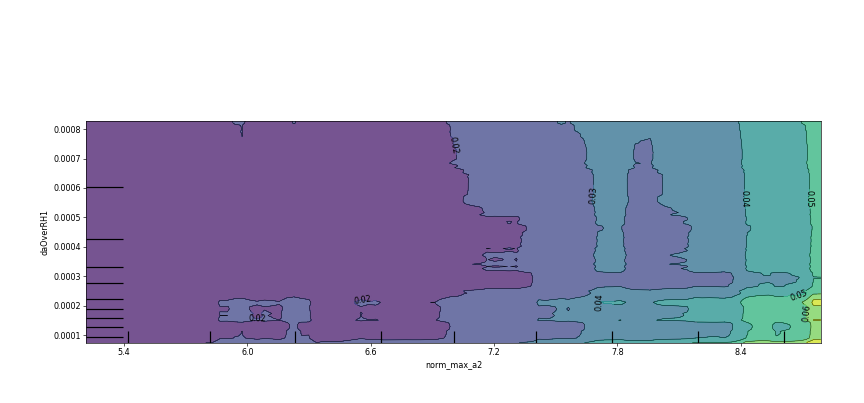

<IPython.core.display.Javascript object>


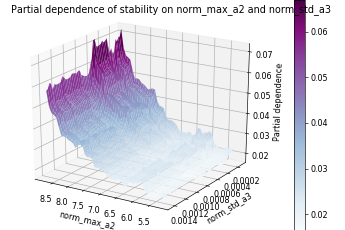

<IPython.core.display.Javascript object>


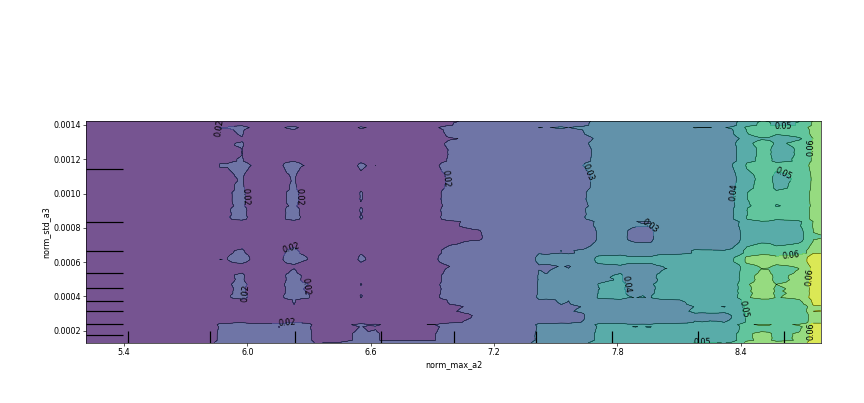

<IPython.core.display.Javascript object>


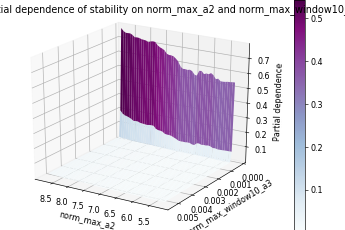

<IPython.core.display.Javascript object>


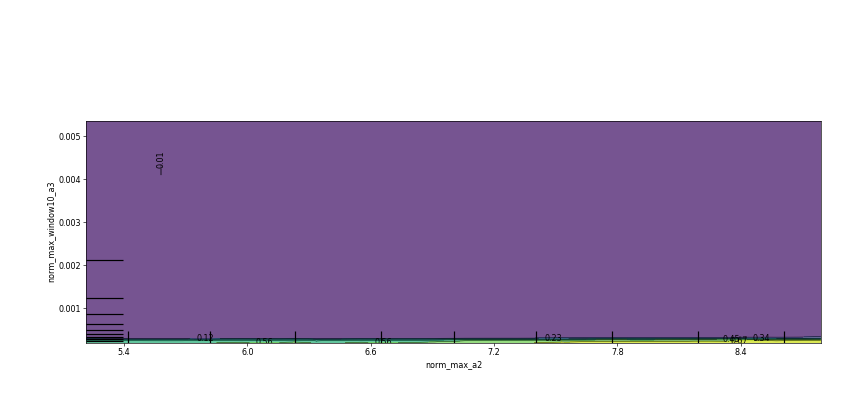

<IPython.core.display.Javascript object>


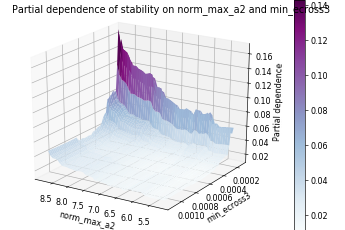

<IPython.core.display.Javascript object>


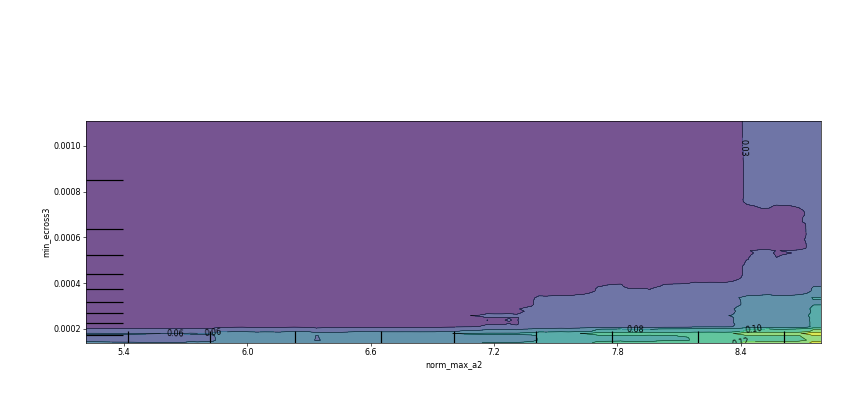

<IPython.core.display.Javascript object>


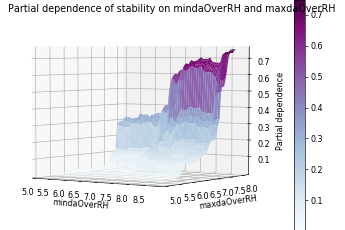

<IPython.core.display.Javascript object>


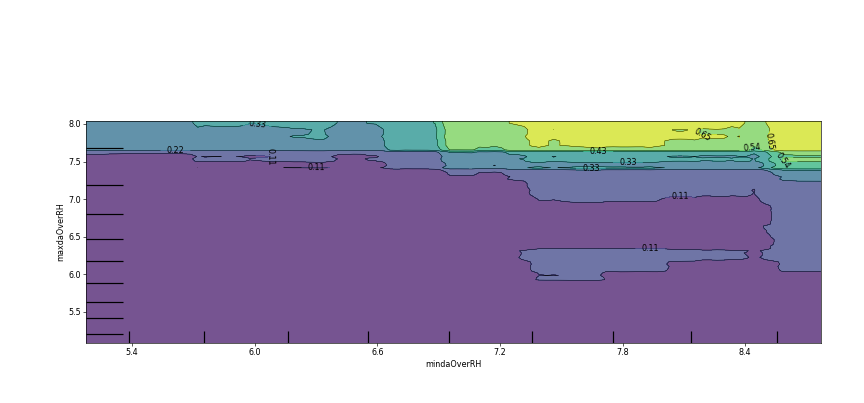

<IPython.core.display.Javascript object>


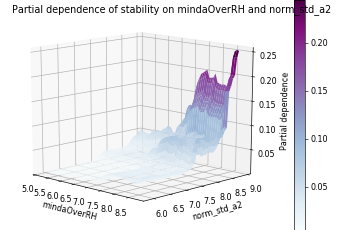

<IPython.core.display.Javascript object>


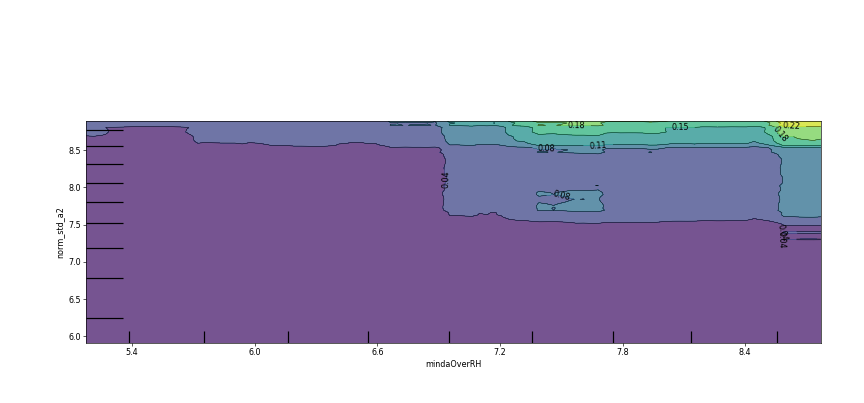

<IPython.core.display.Javascript object>


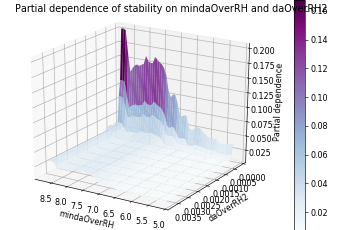

<IPython.core.display.Javascript object>


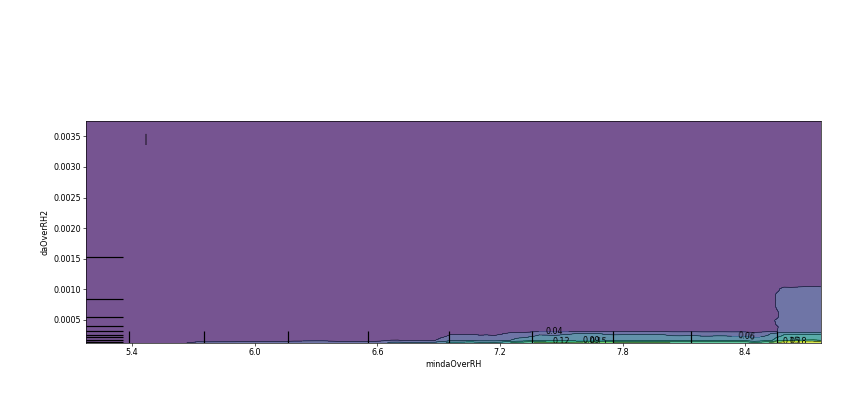

<IPython.core.display.Javascript object>


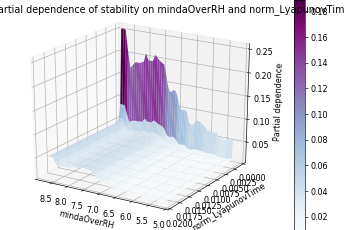

<IPython.core.display.Javascript object>


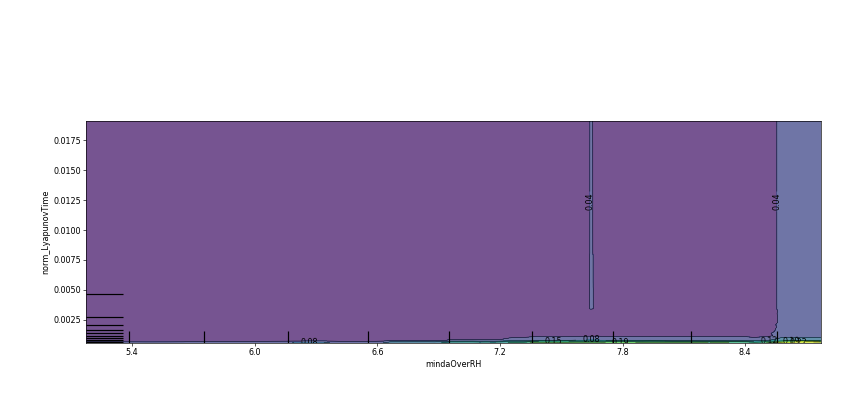

<IPython.core.display.Javascript object>


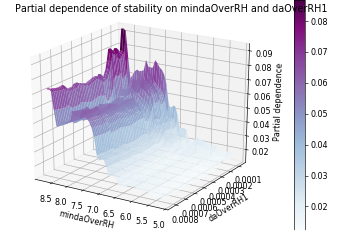

<IPython.core.display.Javascript object>


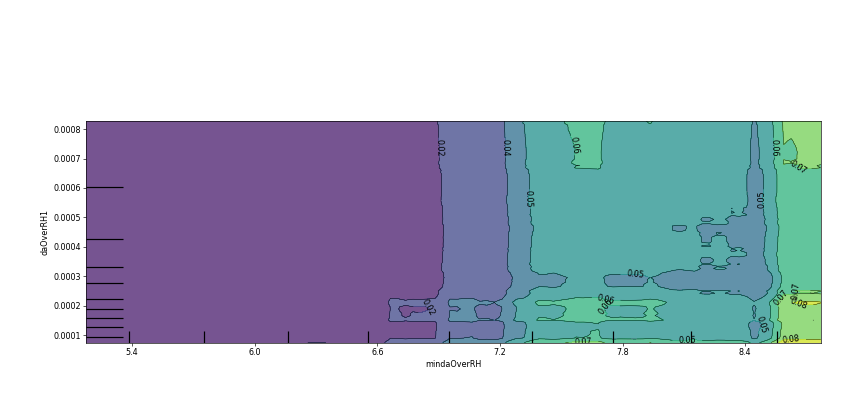

<IPython.core.display.Javascript object>


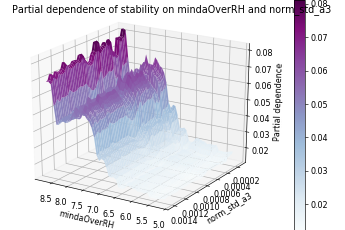

<IPython.core.display.Javascript object>


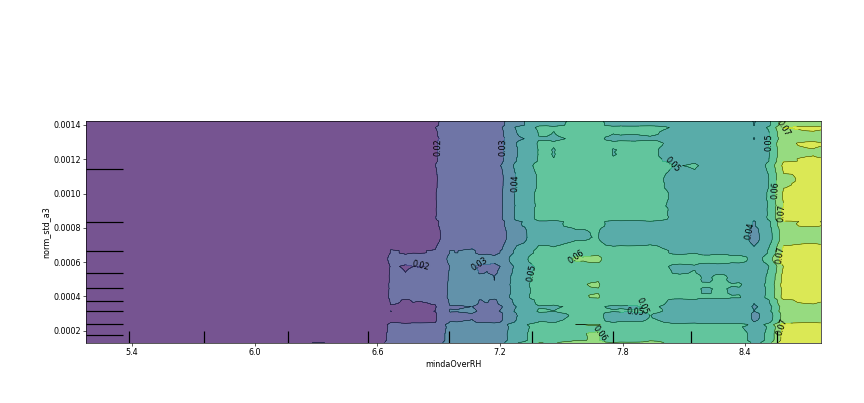

<IPython.core.display.Javascript object>


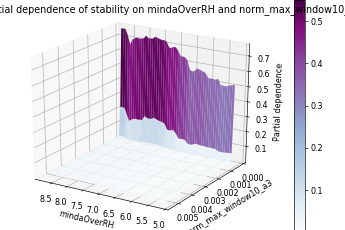

<IPython.core.display.Javascript object>


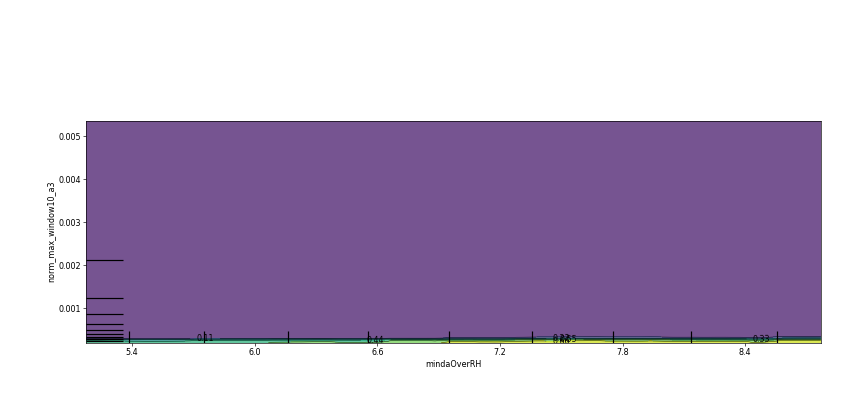

<IPython.core.display.Javascript object>


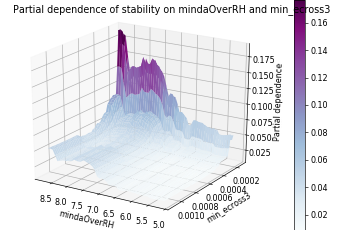

<IPython.core.display.Javascript object>


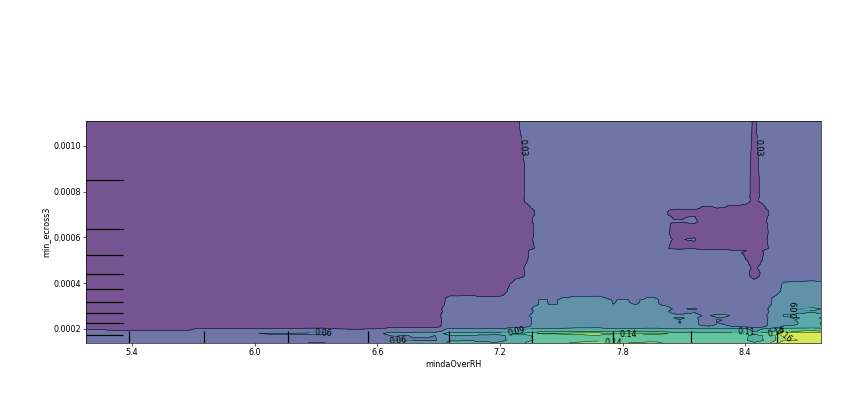

<IPython.core.display.Javascript object>


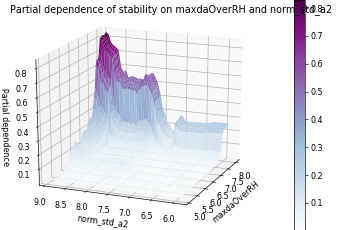

<IPython.core.display.Javascript object>


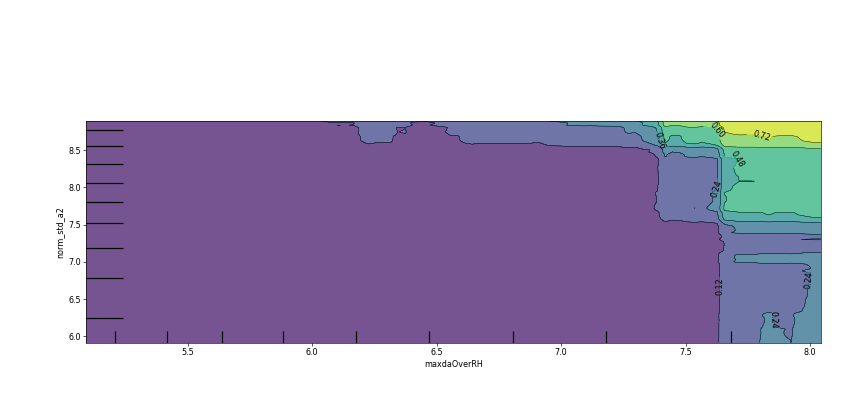

<IPython.core.display.Javascript object>


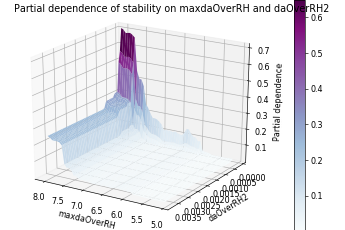

<IPython.core.display.Javascript object>


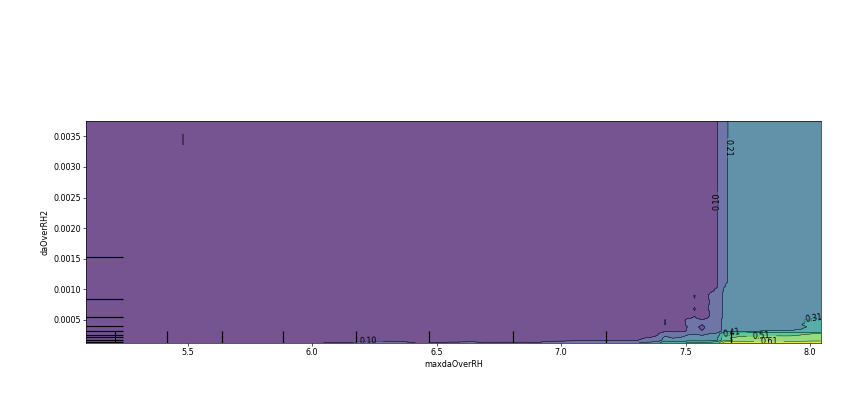

<IPython.core.display.Javascript object>


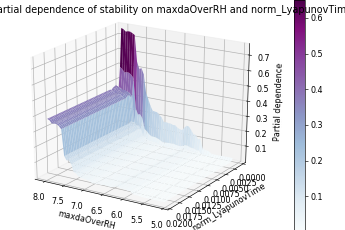

<IPython.core.display.Javascript object>


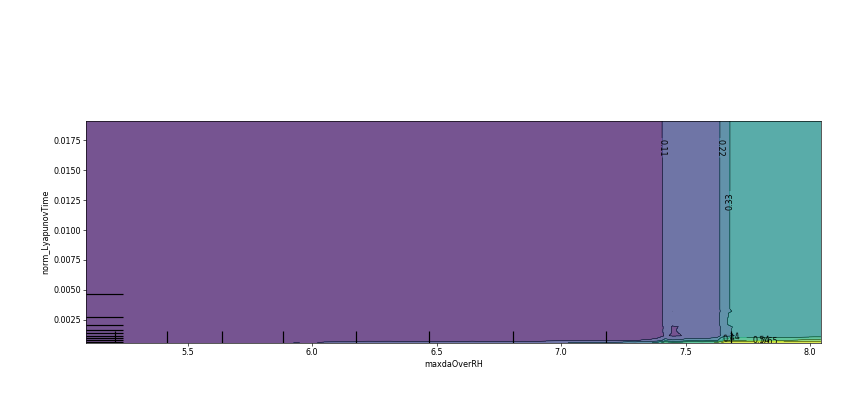

<IPython.core.display.Javascript object>


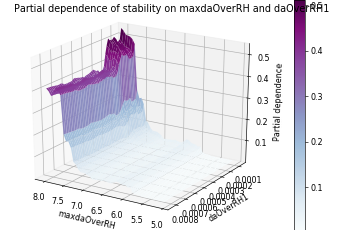

<IPython.core.display.Javascript object>


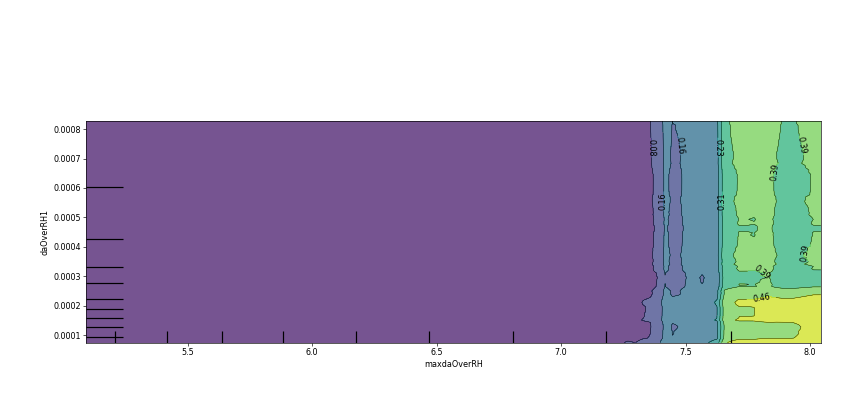

<IPython.core.display.Javascript object>


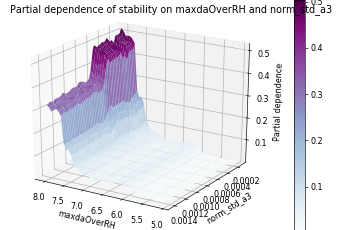

<IPython.core.display.Javascript object>


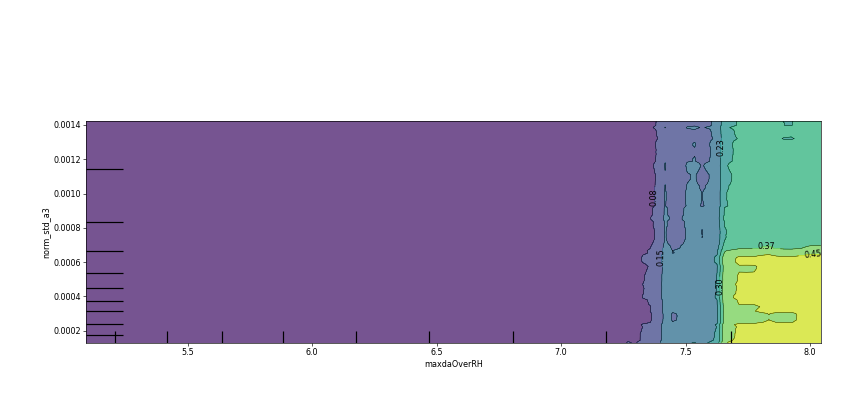

<IPython.core.display.Javascript object>


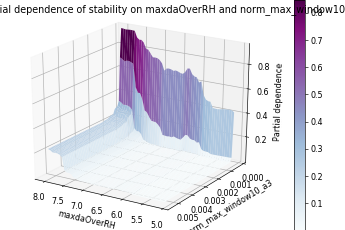

<IPython.core.display.Javascript object>


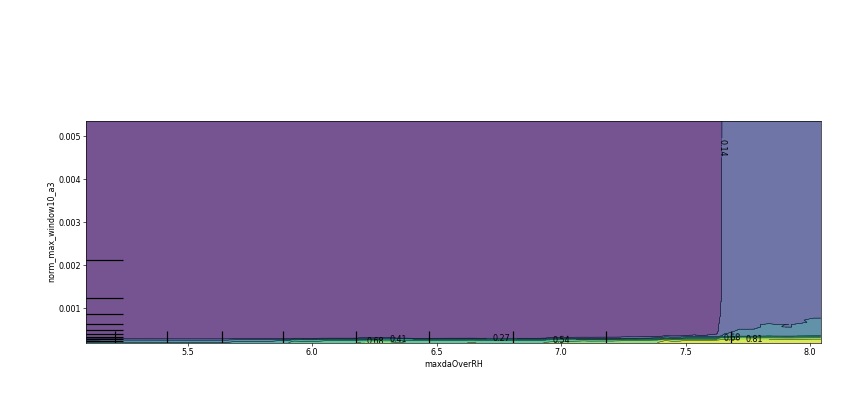

<IPython.core.display.Javascript object>


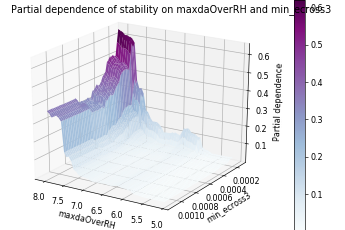

<IPython.core.display.Javascript object>


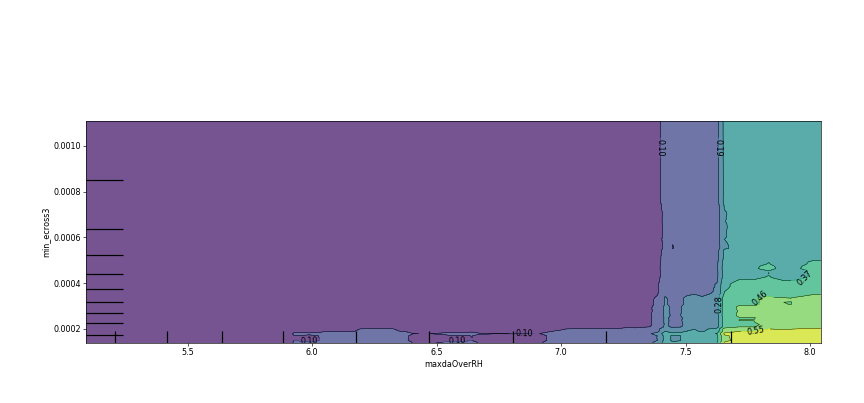

<IPython.core.display.Javascript object>


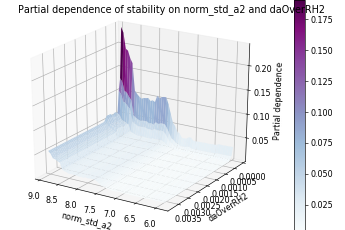

<IPython.core.display.Javascript object>


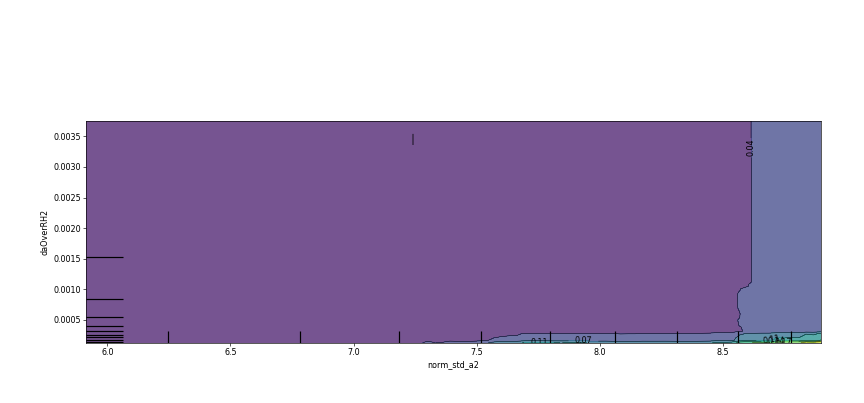

<IPython.core.display.Javascript object>


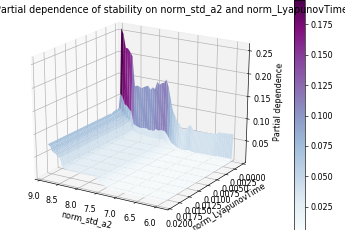

<IPython.core.display.Javascript object>


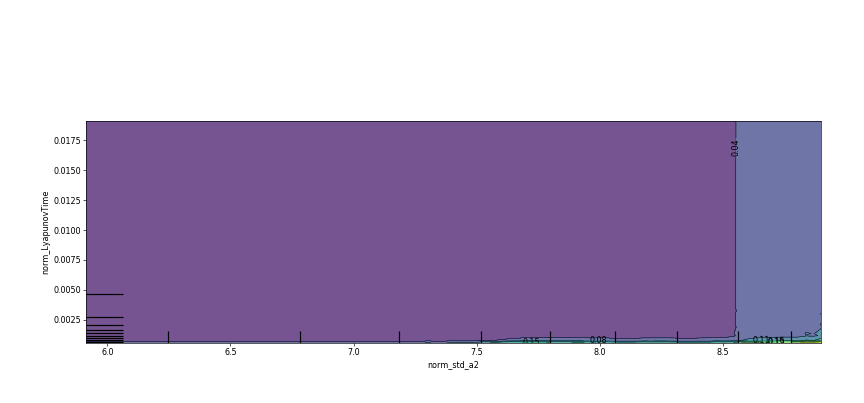

<IPython.core.display.Javascript object>


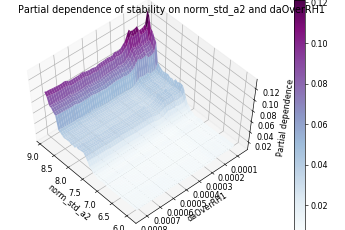

<IPython.core.display.Javascript object>


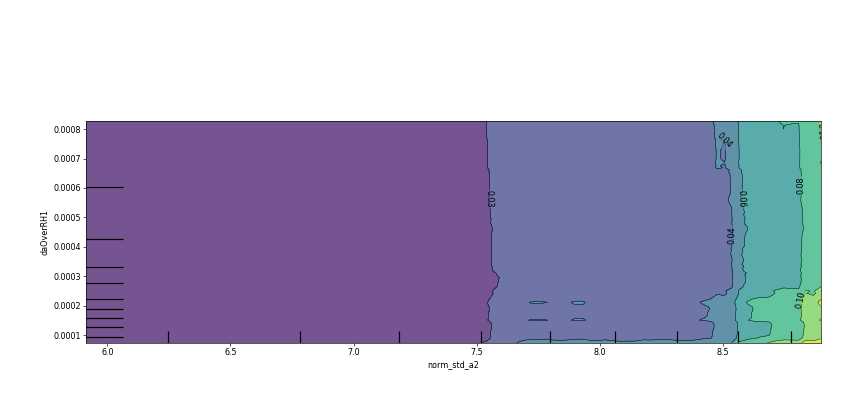

<IPython.core.display.Javascript object>


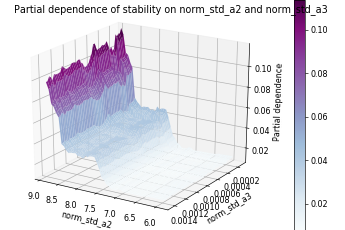

<IPython.core.display.Javascript object>


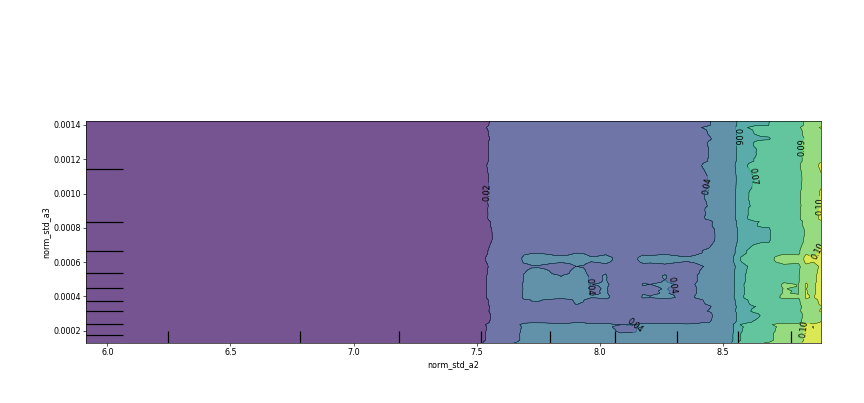

<IPython.core.display.Javascript object>


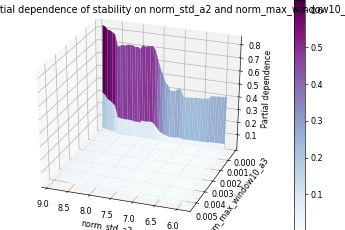

<IPython.core.display.Javascript object>


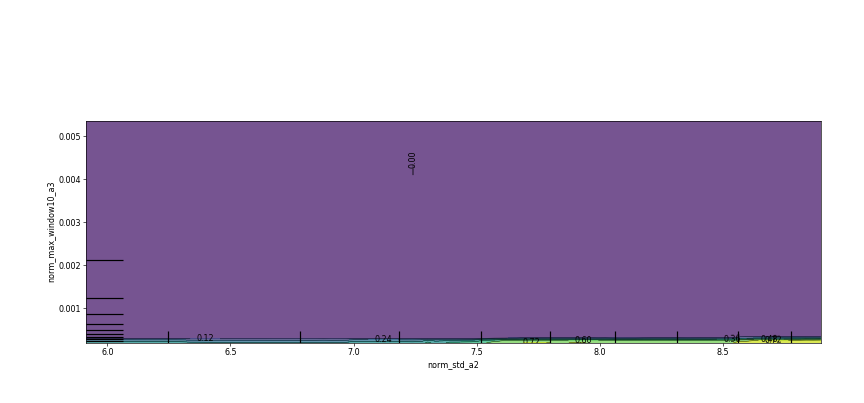

<IPython.core.display.Javascript object>


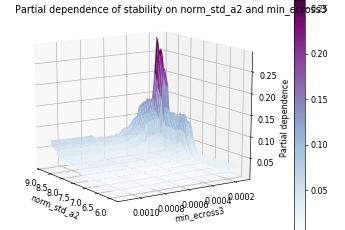

<IPython.core.display.Javascript object>


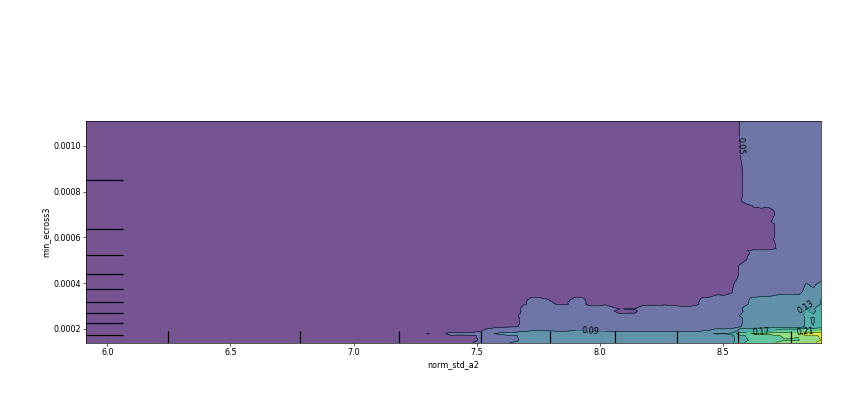

<IPython.core.display.Javascript object>


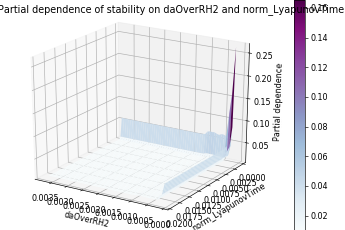

<IPython.core.display.Javascript object>


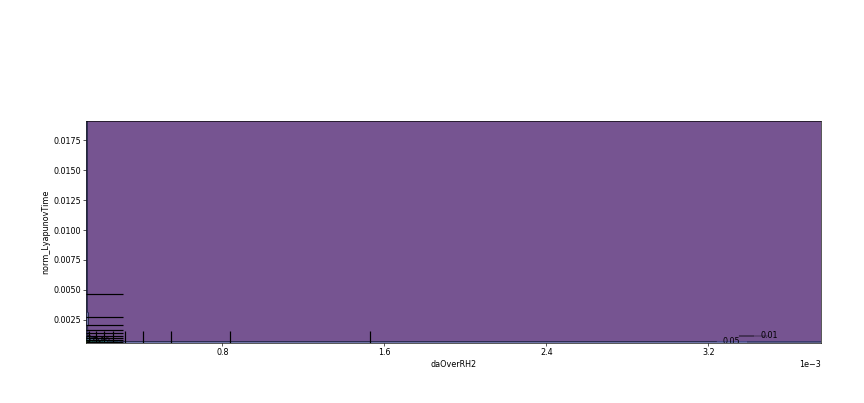

<IPython.core.display.Javascript object>


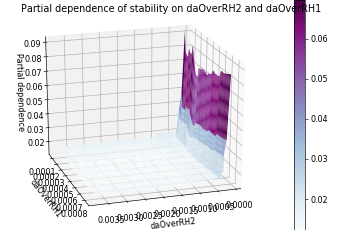

<IPython.core.display.Javascript object>


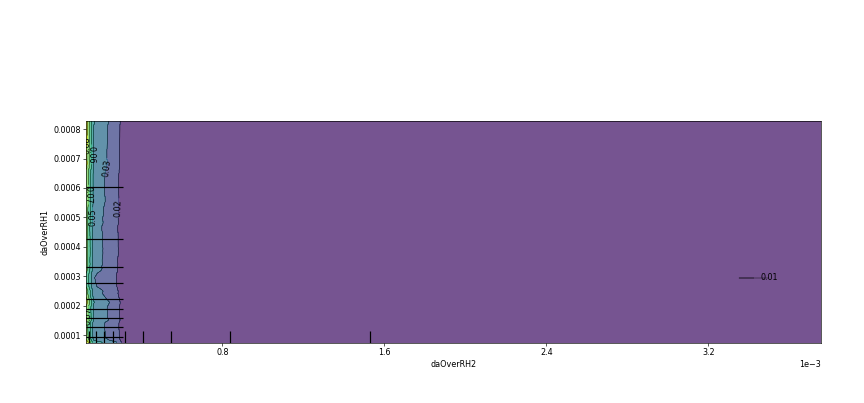

<IPython.core.display.Javascript object>


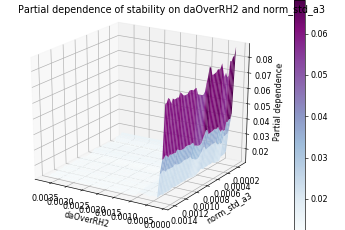

<IPython.core.display.Javascript object>


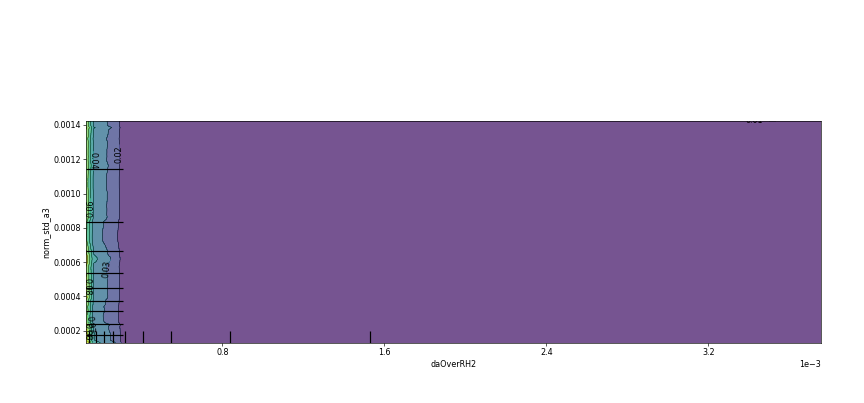

<IPython.core.display.Javascript object>


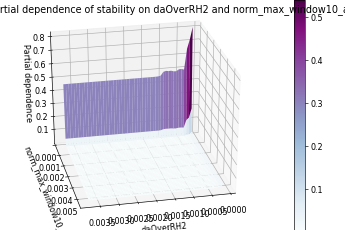

<IPython.core.display.Javascript object>


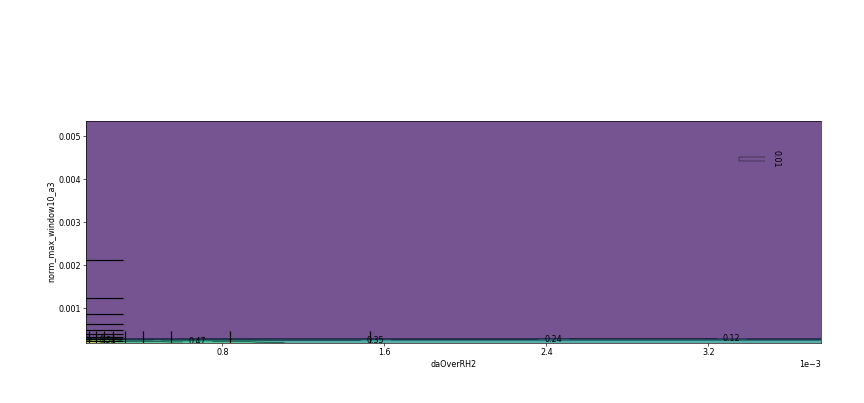

<IPython.core.display.Javascript object>


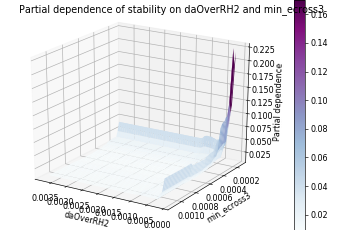

<IPython.core.display.Javascript object>


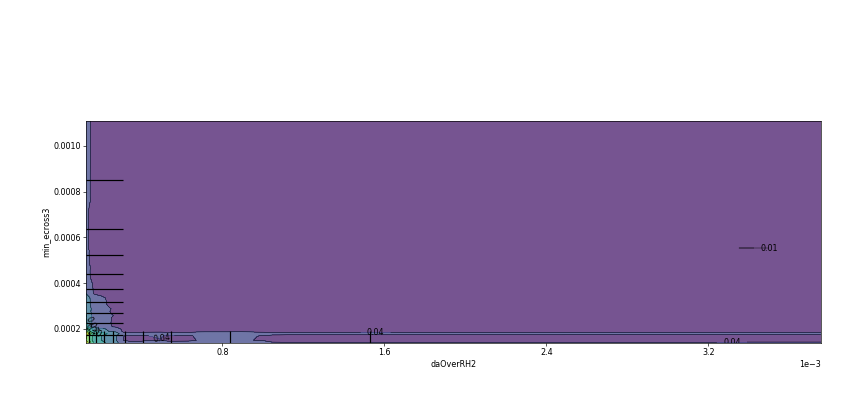

<IPython.core.display.Javascript object>


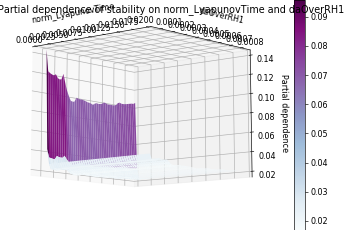

<IPython.core.display.Javascript object>


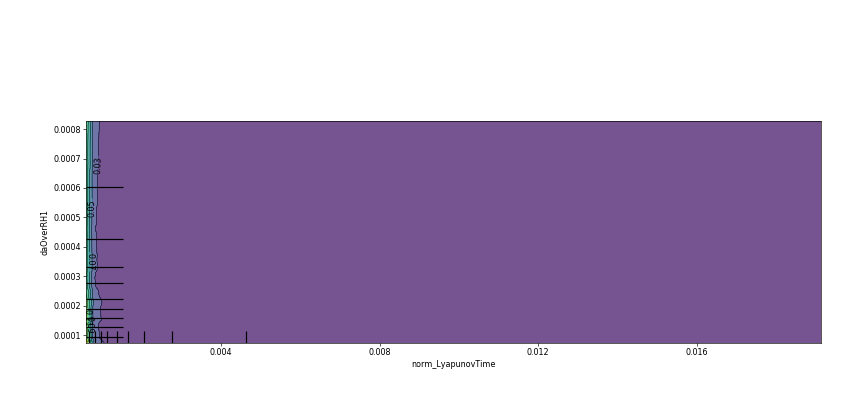

<IPython.core.display.Javascript object>


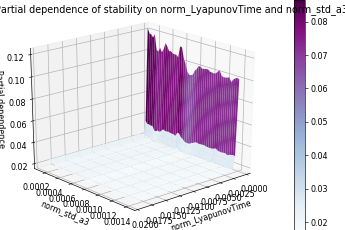

<IPython.core.display.Javascript object>


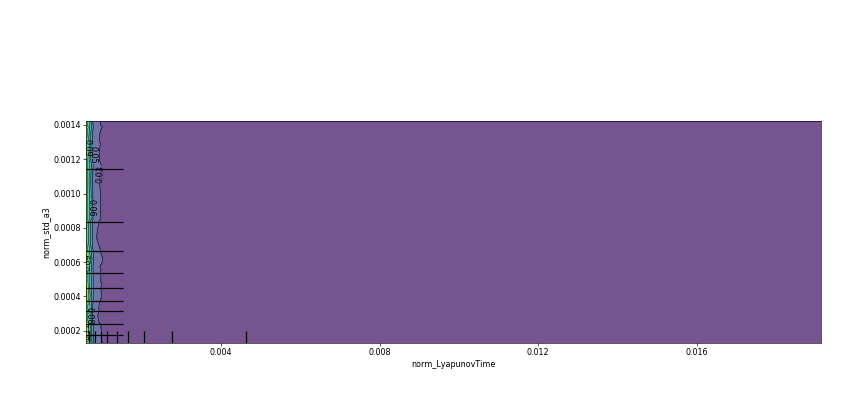

<IPython.core.display.Javascript object>


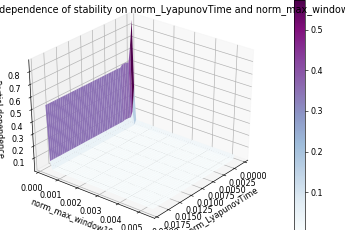

<IPython.core.display.Javascript object>


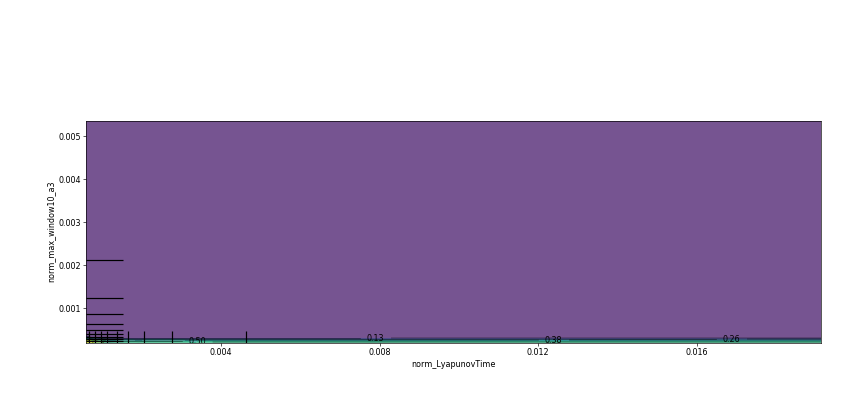

<IPython.core.display.Javascript object>


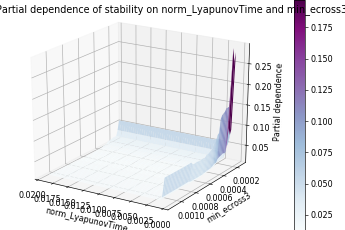

<IPython.core.display.Javascript object>


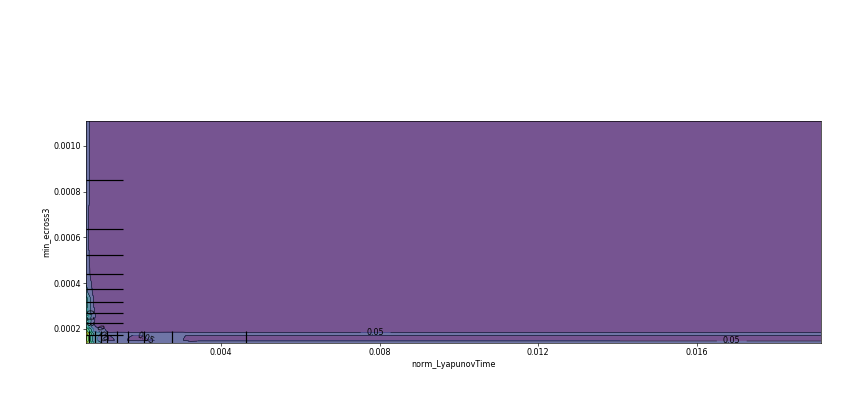

<IPython.core.display.Javascript object>


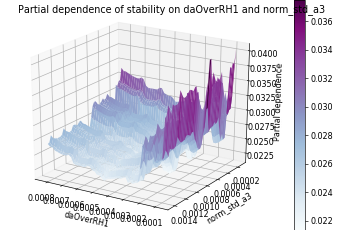

<IPython.core.display.Javascript object>


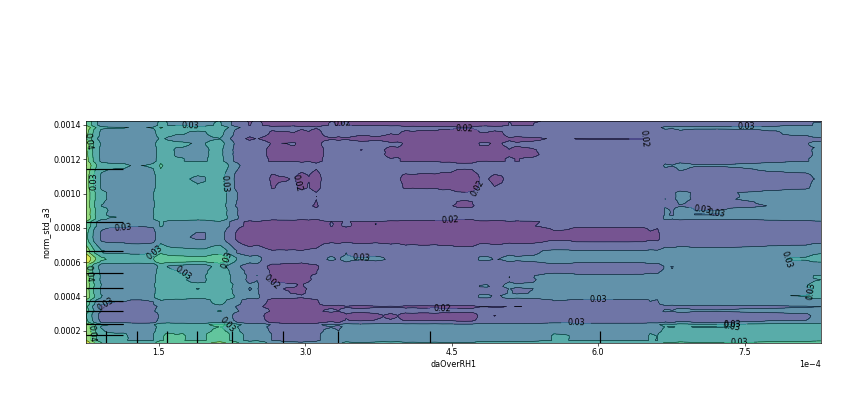

<IPython.core.display.Javascript object>


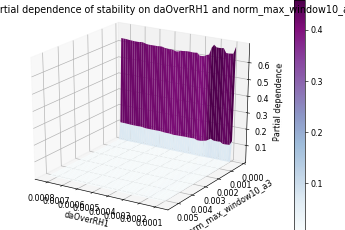

<IPython.core.display.Javascript object>


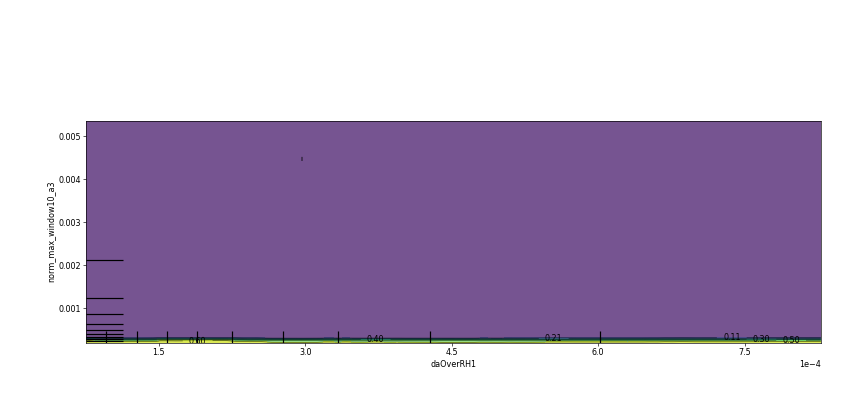

<IPython.core.display.Javascript object>


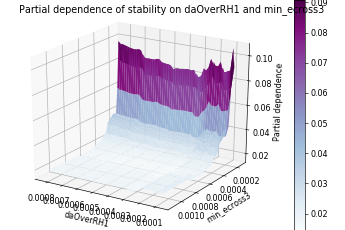

<IPython.core.display.Javascript object>


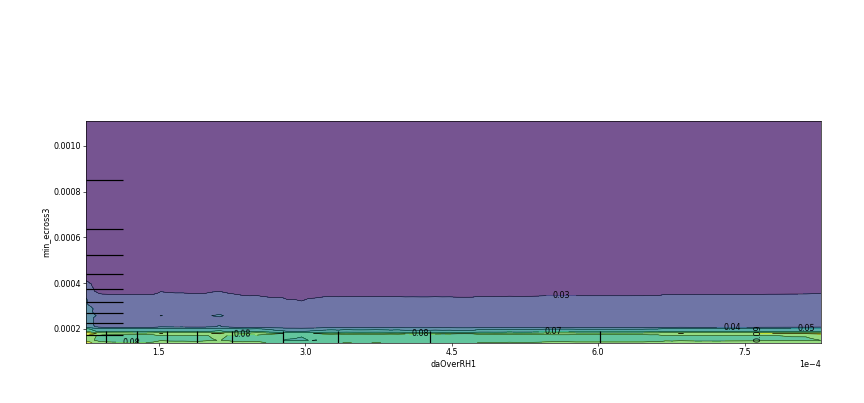

<IPython.core.display.Javascript object>


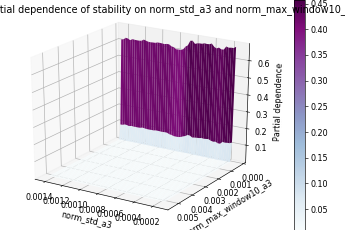

<IPython.core.display.Javascript object>


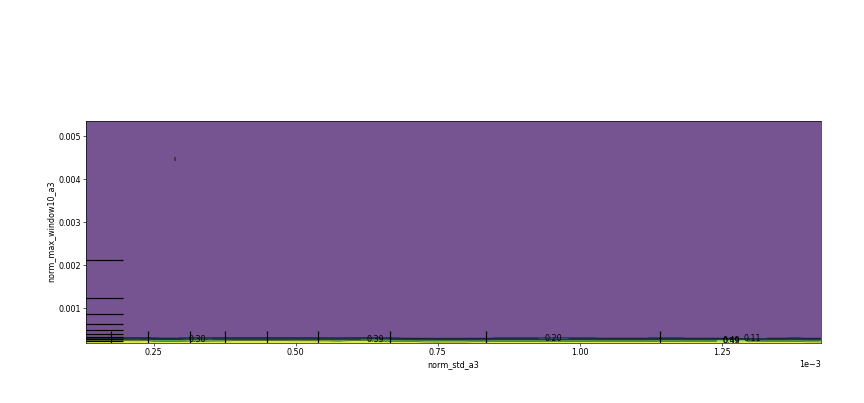

<IPython.core.display.Javascript object>


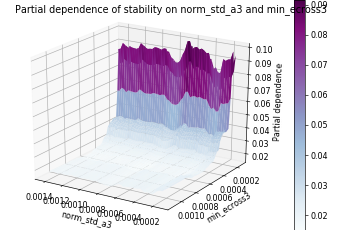

<IPython.core.display.Javascript object>


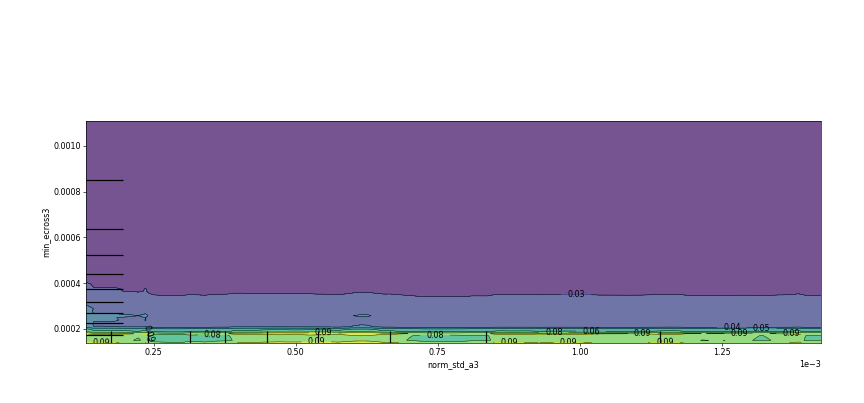

<IPython.core.display.Javascript object>


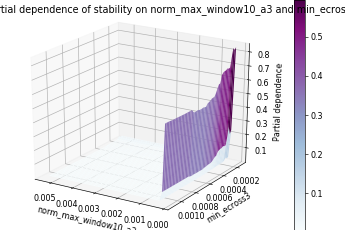

<IPython.core.display.Javascript object>


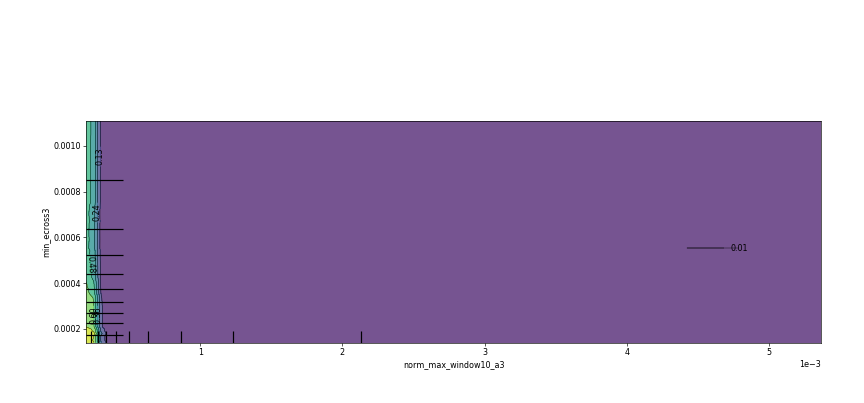

In [13]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence # the proba argument has been added to the PPD function

for pairs in comb:
    names = feature_names_sorted
    
    D3_pdp(pairs, model, X_train, feature_names_sorted)
    
    fig, axs = plot_partial_dependence(model, X_train, [pairs],
                                       feature_names=feature_names_sorted,
                                       grid_resolution=100, figsize=(15,7), proba=True)
    
    
    
   
    plt.show()
    
    